## Setting up my Environment
### This being assesment test, i'll only focus on the deliverables because of time

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the data and ensure you replace the path
#converted the data to csv file and droped first 2 columns
data=pd.read_csv('Junior Data Analyst _ Data.xlsx - Raw Data.csv')

In [3]:
data.head()

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh)
0,0,1/1/20 0:00,0.0,1.5098490
1,1,1/1/20 1:00,0.0,1.4118588
2,2,1/1/20 2:00,0.0,1.0238976
3,3,1/1/20 3:00,0.0,0.6420000
4,4,1/1/20 4:00,0.0,0.9600000


* The electricity usage(kwh) needs to be changed from object to float
* 2020 is a leap year so i expected 8784hrs instead of 8760

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Hour                                8760 non-null   int64  
 1   Date/hour start                     8760 non-null   object 
 2   Solar electricity generation (kWh)  8760 non-null   float64
 3   Electricity usage (kWh)             8760 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 273.9+ KB


In [5]:
# Clean the data: Remove commas and convert to float
data['Electricity usage (kWh)'] = data['Electricity usage (kWh)'].str.replace(',', '').astype(float)


* There are outliers since the max is way greater than the 75%

In [6]:
data.describe()

,Hour,Solar electricity generation (kWh),Electricity usage (kWh)
count,8760.000000,8760.000000,8760.000000
mean,11.500000,1.116750,7.312704
std,6.922582,2.026098,491.479806
min,0.000000,0.000000,-12.624000
25%,5.750000,0.000000,0.300000
50%,11.500000,0.024000,0.621000
75%,17.250000,1.272750,1.686000
max,23.000000,13.050000,46000.000000


In [7]:
# Calculate the 95th percentile
percentile_95 = data['Electricity usage (kWh)'].quantile(0.95)

# Count values above and below the 75th percentile
values_above_95 = data[data['Electricity usage (kWh)'] > percentile_95]
values_below_95 = data[data['Electricity usage (kWh)'] <= percentile_95]

# Print the counts
print("Values above the 95th percentile:", len(values_above_95))
print("Values below or equal to the 95th percentile:", len(values_below_95))

Values above the 95th percentile: 438
Values below or equal to the 95th percentile: 8322


* Before we decide what to do with the outliers,lets continue exploring the data
* I chose not to drop the outliers

In [8]:
data.duplicated().any()
#no duplicates

False

In [9]:
data.isnull().any()
#no nulls

Hour                                  False
Date/hour start                       False
Solar electricity generation (kWh)    False
Electricity usage (kWh)               False
dtype: bool

## Deliverable1
* creating a graph showing the average solar electricity generation and average electricity usage for each hour in a day

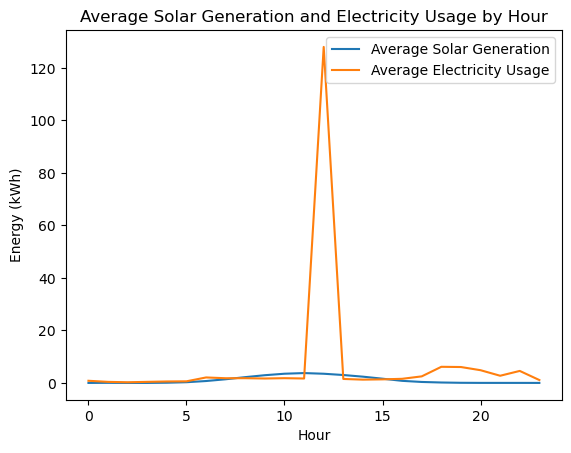

In [10]:
# Data visualization
avg_hourly_data = data.groupby('Hour').mean()
plt.plot(avg_hourly_data['Solar electricity generation (kWh)'], label='Average Solar Generation')
plt.plot(avg_hourly_data['Electricity usage (kWh)'], label='Average Electricity Usage')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.title('Average Solar Generation and Electricity Usage by Hour')
plt.legend()
# Save the plot to a file
plt.savefig('average_generation_usage_plot.png')

## Calculation deliverables

      Date/hour start  ElectricityNeeded  ExcessSolarGeneration  \
0 2020-01-01 00:00:00           1.509849                    0.0   
1 2020-01-01 01:00:00           1.411859                    0.0   
2 2020-01-01 02:00:00           1.023898                    0.0   
3 2020-01-01 03:00:00           0.642000                    0.0   
4 2020-01-01 04:00:00           0.960000                    0.0   

   BatteryCharge  ElectricityPurchasedWithBattery  SavingsWithBattery  
0            0.0                         1.509849            0.256674  
1            0.0                         1.411859            0.240016  
2            0.0                         1.023898            0.174063  
3            0.0                         0.642000            0.109140  
4            0.0                         0.960000            0.163200  


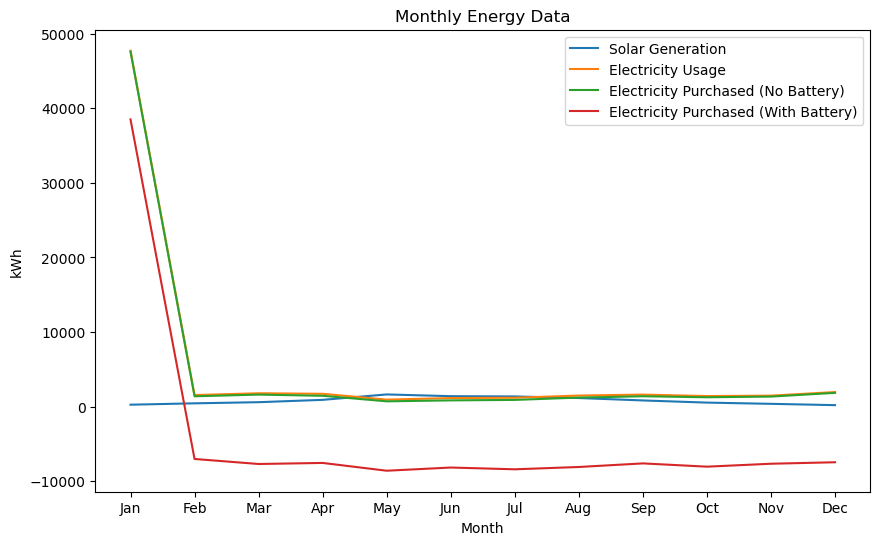

In [11]:
#convert to datetime formart
data['Date/hour start'] = pd.to_datetime(data['Date/hour start'])

# Calculate electricity needed to be bought from the electricity provider
data['ElectricityNeeded'] = data['Electricity usage (kWh)'] - data['Solar electricity generation (kWh)']
data['ElectricityNeeded'] = data['ElectricityNeeded'].clip(lower=0)  # Set negative values to zero

# Calculate excess solar electricity generated
data['ExcessSolarGeneration'] = data['Solar electricity generation (kWh)'] - data['Electricity usage (kWh)']
data['ExcessSolarGeneration'] = data['ExcessSolarGeneration'].clip(lower=0)  # Set negative values to zero

# Model cumulative battery charge
battery_capacity = 12.5 #in kwh  
data['BatteryCharge'] = 0
for index, row in data.iterrows():
    if index > 0:
        data.at[index, 'BatteryCharge'] = min(data.at[index - 1, 'BatteryCharge'] + row['ExcessSolarGeneration'], battery_capacity)

# Calculate electricity purchased when battery is charged
data['ElectricityPurchasedWithBattery'] = data['ElectricityNeeded'] - data['BatteryCharge']

# Calculate savings with battery
electricity_price = 0.17  # $/kWh
data['SavingsWithBattery'] = data['ElectricityPurchasedWithBattery'] * electricity_price

# Group data by month
data['Month'] = data['Date/hour start'].dt.month
monthly_data = data.groupby('Month').sum()

# Create a chart for monthly data
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['Solar electricity generation (kWh)'], label='Solar Generation')
plt.plot(monthly_data.index, monthly_data['Electricity usage (kWh)'], label='Electricity Usage')
plt.plot(monthly_data.index, monthly_data['ElectricityNeeded'], label='Electricity Purchased (No Battery)')
plt.plot(monthly_data.index, monthly_data['ElectricityPurchasedWithBattery'], label='Electricity Purchased (With Battery)')
plt.xlabel('Month')
plt.ylabel('kWh')
plt.title('Monthly Energy Data')
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# Save the plot to a file
plt.savefig('chart.png')

# Print some summary data
print(data[['Date/hour start', 'ElectricityNeeded', 'ExcessSolarGeneration', 'BatteryCharge', 'ElectricityPurchasedWithBattery', 'SavingsWithBattery']].head())


In [12]:
data

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh),ElectricityNeeded,ExcessSolarGeneration,BatteryCharge,ElectricityPurchasedWithBattery,SavingsWithBattery,Month
0,0,2020-01-01 00:00:00,0.000,1.509849,1.509849,0.0,0.0,1.509849,0.256674,1
1,1,2020-01-01 01:00:00,0.000,1.411859,1.411859,0.0,0.0,1.411859,0.240016,1
2,2,2020-01-01 02:00:00,0.000,1.023898,1.023898,0.0,0.0,1.023898,0.174063,1
3,3,2020-01-01 03:00:00,0.000,0.642000,0.642000,0.0,0.0,0.642000,0.109140,1
4,4,2020-01-01 04:00:00,0.000,0.960000,0.960000,0.0,0.0,0.960000,0.163200,1
...,...,...,...,...,...,...,...,...,...,...
8755,19,2020-12-31 19:00:00,0.012,4.395600,4.383600,0.0,12.5,-8.116400,-1.379788,12
8756,20,2020-12-31 20:00:00,0.003,4.560600,4.557600,0.0,12.5,-7.942400,-1.350208,12
8757,21,2020-12-31 21:00:00,0.000,2.022000,2.022000,0.0,12.5,-10.478000,-1.781260,12
8758,22,2020-12-31 22:00:00,0.015,1.668000,1.653000,0.0,12.5,-10.847000,-1.843990,12


## Deliverable3


In [13]:
!pip install numpy-financial


In [14]:
data.columns

Index(['Hour', 'Date/hour start', 'Solar electricity generation (kWh)',
       'Electricity usage (kWh)', 'ElectricityNeeded', 'ExcessSolarGeneration',
       'BatteryCharge', 'ElectricityPurchasedWithBattery',
       'SavingsWithBattery', 'Month'],
      dtype='object')

In [15]:

import numpy_financial as npf


# Calculate savings from installing a battery (for 2020, as previously calculated)
data['SavingsWithBattery'] = (data['ElectricityNeeded'] - data['ElectricityPurchasedWithBattery']) * electricity_price

# Calculate average annual savings for 2020
avg_annual_savings = data['SavingsWithBattery'].sum()

# Scenario parameters
years = 20
initial_cost_battery = 7000  

# Electricity price scenarios
electricity_price_increase = 0.04  # 4% p.a. increase
electricity_price_increase_naomi = 0.0425  # 4% + 0.25% p.a. increase

# Calculate projected annual savings for the two scenarios
savings_scenario1 = [avg_annual_savings * (1 + electricity_price_increase)**year for year in range(1, years + 1)]
savings_scenario2 = [avg_annual_savings * (1 + electricity_price_increase_naomi)**year for year in range(1, years + 1)]

# Calculate Net Present Value (NPV) for the two scenarios
discount_rate = 0.05  # Example discount rate
npv_scenario1 = npf.npv(discount_rate, [-initial_cost_battery] + savings_scenario1)
npv_scenario2 = npf.npv(discount_rate, [-initial_cost_battery] + savings_scenario2)

# Calculate Internal Rate of Return (IRR) for the two scenarios
irr_scenario1 = npf.irr([-initial_cost_battery] + savings_scenario1)
irr_scenario2 = npf.irr([-initial_cost_battery] + savings_scenario2)

print("Scenario 1:")
print("Projected Annual Savings:", savings_scenario1)
print("NPV:", npv_scenario1)
print("IRR:", irr_scenario1)

print("\nScenario 2:")
print("Projected Annual Savings:", savings_scenario2)
print("NPV:", npv_scenario2)
print("IRR:", irr_scenario2)


Scenario 1:
Projected Annual Savings: [19322.594876, 20095.49867104, 20899.3186178816, 21735.291362596865, 22604.70301710074, 23508.891137784773, 24449.24678329616, 25427.216654628006, 26444.30532081313, 27502.077533645654, 28602.160634991484, 29746.247060391146, 30936.09694280679, 32173.540820519065, 33460.48245333983, 34798.90175147342, 36190.85782153236, 37638.49213439366, 39144.0318197694, 40709.79309256018]
NPV: 329577.82948172715
IRR: 2.8003706965561164

Scenario 2:
Projected Annual Savings: [19369.043421374998, 20192.227766783435, 21050.39744687173, 21945.03933836378, 22877.703510244235, 23850.00590942962, 24863.631160580375, 25920.33548490504, 27021.949743013505, 28170.382607091582, 29367.62386789297, 30615.74788227842, 31916.917167275256, 33273.38614688445, 34687.50505812704, 36161.72402309744, 37698.59729407908, 39300.78767907744, 40971.07115543823, 42712.341679544355]
NPV: 337940.4237121231
IRR: 2.809506203038229


## The end!